In [14]:
'''
统计工具：
①自回归模型
②马尔科夫模型
③因果关系
'''
# √
%matplotlib inline
import torch
from torch import nn
import d2l.torch as d2l
from torch.nn import functional as F

'1\n代码调用d2l.plot函数来将生成的时间序列数据进行可视化。\n该函数的第一个参数是x轴的数据，这里传入time；\n第二个参数是y轴的数据，这里传入生成的时间序列数据x；\n第三个参数是x轴的标签，这里设为"time"；\n第四个参数是y轴的标签，这里设为"x"；\nxlim参数设置x轴的显示范围，这里设定为[1, 1000]；\nfigsize参数指定图像的大小，这里设定为(6,3)。\n\n'

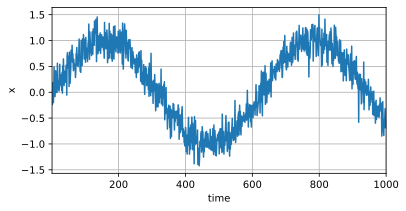

In [15]:
T = 1000 # 总共产生1000个点
# 代码定义了一个变量T，表示生成数据的总点数，这里设定为1000。

time = torch.arange(1,T+1,dtype=torch.float32)
# 使用torch.arange函数创建一个包含从1到T的序列，数据类型为torch.float32，并将其赋值给变量time。

x = torch.sin(0.01*time) + torch.normal(0,0.2,size=(T,))
# 使用torch.sin函数生成一个与time有关的正弦波形，
# 并使用torch.normal函数添加一些高斯噪声。
# torch.normal的参数是均值和标准差，这里设置为0和0.2，表示均值为0，标准差为0.2的高斯噪声。
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))
'''1
代码调用d2l.plot函数来将生成的时间序列数据进行可视化。
该函数的第一个参数是x轴的数据，这里传入time；
第二个参数是y轴的数据，这里传入生成的时间序列数据x；
第三个参数是x轴的标签，这里设为"time"；
第四个参数是y轴的标签，这里设为"x"；
xlim参数设置x轴的显示范围，这里设定为[1, 1000]；
figsize参数指定图像的大小，这里设定为(6,3)。

'''

In [16]:
help(torch.normal)

Help on built-in function normal in module torch:

normal(...)
    normal(mean, std, *, generator=None, out=None) -> Tensor
    
    Returns a tensor of random numbers drawn from separate normal distributions
    whose mean and standard deviation are given.
    
    The :attr:`mean` is a tensor with the mean of
    each output element's normal distribution
    
    The :attr:`std` is a tensor with the standard deviation of
    each output element's normal distribution
    
    The shapes of :attr:`mean` and :attr:`std` don't need to match, but the
    total number of elements in each tensor need to be the same.
    
    .. note:: When the shapes do not match, the shape of :attr:`mean`
              is used as the shape for the returned output tensor
    
    .. note:: When :attr:`std` is a CUDA tensor, this function synchronizes
              its device with the CPU.
    
    Args:
        mean (Tensor): the tensor of per-element means
        std (Tensor): the tensor of per-element st

In [17]:
# 将这个序列转换为模型的特征-标签对
tau = 4
features = torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i]=x[i:T-tau+i]
labels = x[tau:].reshape((-1,1))

In [18]:
batch_size,n_train = 16,600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train],labels[:n_train]),
                            batch_size,is_train=True)

In [19]:
# √
# 使用一个相当简单的架构训练模型：
# 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失


# 初始化网络权重和函数
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )
    net.apply(init_weight)
    return net
# 平方损失。MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [20]:
# 训练模型
def train(net,train_iter,loss,epochs,lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch{epoch+1},'
              f'loss:{d2l.evaluate_loss(net,train_iter,loss):f}')

In [21]:
net = get_net()
train(net,train_iter,loss,5,0.01)

epoch1,loss:0.065700
epoch2,loss:0.055471
epoch3,loss:0.052802
epoch4,loss:0.053137
epoch5,loss:0.049770


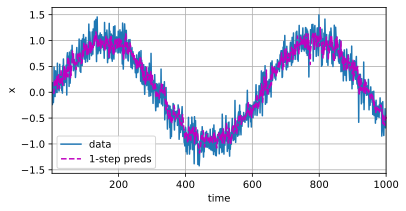

In [22]:
# 预测
onestep_preds = net(features)
d2l.plot([time,time[tau:]],
         [x.detach().numpy(),onestep_preds.detach().numpy()],'time',
         'x',legend=['data','1-step preds'],xlim=[1,1000],
         figsize=(6,3)
         )

# time[tau:]丢弃前tau个数据
# 1个x  2个y的表示

In [23]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train+tau]
for i in range(n_train+tau,T):
    multistep_preds[i]=net(
        multistep_preds[i-tau:i].reshape((1,-1))
    )

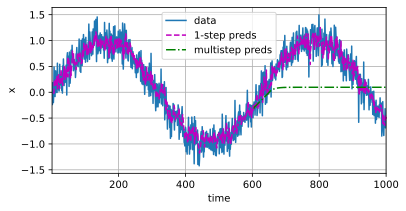

In [24]:
d2l.plot(
    [time,time[tau:],time[n_train+tau:]],
    [x.detach().numpy(),
     onestep_preds.detach().numpy(),
     multistep_preds[n_train+tau:].detach().numpy()],
    'time','x',legend=['data','1-step preds','multistep preds'],
    xlim=[1,1000],figsize=(6,3)
)

In [25]:
max_steps = 64
features = torch.zeros((T-tau-max_steps + 1,tau+max_steps))
# 列i(i＜tau)是来自x的观测，其时间步从（i）到（i+T-tau+max_steps+1）
for i in range(tau):
    features[:,i] = x[i:i+T-tau-max_steps+1]

# 列i(i＞tau)是来自(i-tau+1)步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau,tau+max_steps):
    features[:,i] = net(features[:,i-tau:i]).reshape(-1)


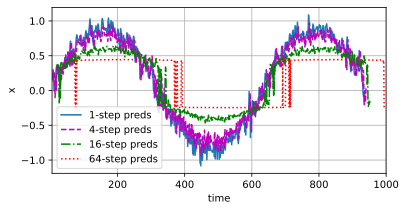

In [12]:
steps = (1,4,16,64)
d2l.plot([time[tau+i-1:T-max_steps+i] for i in steps],
         [features[:,tau+i-1].detach().numpy() for i in steps],
         'time','x',legend=[f'{i}-step preds' for i in steps],xlim=[5,1000],
         figsize=(6,3)
         )

In [26]:
# 文本预处理
import collections
import re
from d2l import torch as d2l

In [27]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

In [28]:
def read_time_machine():
    # 将时间机器数据集加载到文本行的列表中
    with open(d2l.download('time_machine'),'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+',' ',line).strip().lower() for line in lines]

In [29]:
lines = read_time_machine()
print(f'# 文本总行数：{len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数：3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [30]:
def tokenize(lines,token='word'):
    if token=='word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：'+token)

In [31]:
tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [32]:
def count_corpus(tokens):
    # 统计词元的频率
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0],list):
        # 将词元列表展开成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [33]:
class Vocab:
    def __init__(self,tokens=None,min_freq=0,reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(),key=lambda x:x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token:idx
                             for idx,token in enumerate(self.idx_to_token)}
        for token,freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self,tokens):
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self,indices):
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    def unk(self):
        return 0
    def token_freqs(self):
        return self._token_freqs


In [34]:
# 使用时光机器数据集作为语料库构建词表，然后打印前几个高频词元及其索引
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [35]:
# 将文本行转换成数字索引列表
for i in [0,10]:
    print('文本：',tokens[i])
    print('索引：',vocab[tokens[i]])

文本： ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引： [1, 19, 50, 40, 2183, 2184, 400]
文本： ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引： [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [36]:
def load_corpus_time_machine(max_tokens=-1):
    # 返回时光机器数据集的词元索引列表和词表
    lines = read_time_machine()
    tokens = tokenize(lines,'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据中的每个文本行不一定是一个句子或一个段落
    # 所以将所有文本展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens>0:
        corpus = corpus[:max_tokens]
    return corpus,vocab

In [37]:
corpus,vocab = load_corpus_time_machine()
len(corpus),len(vocab)

(170580, 28)

In [38]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

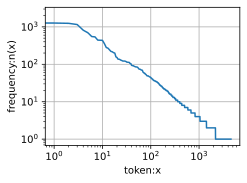

In [39]:
# 词频图
freqs = [freq for token,freq in vocab.token_freqs]
d2l.plot(freqs,xlabel='token:x',ylabel='frequency:n(x)',
         xscale='log',yscale='log')

In [40]:
bigram_tokens = [pair for pair in zip(corpus[:-1],corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [41]:
# 值得注意的是：在10个最频繁的词对中，有九个是由2个停用词组成
# 只有一个与‘the time’有关，接下来看三元语法是否表现出相同的行为方式
trigram_tokens = [triple for triple in zip(
    corpus[:-2],corpus[1:-1],corpus[2:]
)]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

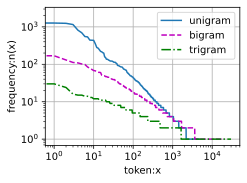

In [42]:
# 最直观的比较一元语法、二元语法和三元语法
bigram_freqs = [freq for token,freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token,freq in trigram_vocab.token_freqs]

d2l.plot([freqs,bigram_freqs,trigram_freqs],xlabel='token:x',
         ylabel='frequency:n(x)',xscale='log',yscale='log',
         legend=['unigram','bigram','trigram'])  #?

In [47]:
import random

In [51]:
def seq_data_iter_random(corpus,batch_size,num_steps):
    corpus = corpus[random.randint(0,num_steps-1):]
    num_subseqs = (len(corpus)-1) // num_steps
    initial_indices = list(range(0,num_subseqs*num_steps,num_steps))
    random.shuffle(initial_indices)
    def data(pos):
        return corpus[pos:pos+num_steps]
    num_batches = num_subseqs // batch_size
    for i in range(0,batch_size*num_batches,batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j+1) for j in initial_indices_per_batch]
        yield torch.tensor(X),torch.tensor(Y)

In [52]:
my_seq = list(range(35))
for X,Y in seq_data_iter_random(my_seq,batch_size=2,num_steps=5):
    print('X:',X,'\n Y:',Y)

X: tensor([[ 2,  3,  4,  5,  6],
        [22, 23, 24, 25, 26]]) 
 Y: tensor([[ 3,  4,  5,  6,  7],
        [23, 24, 25, 26, 27]])
X: tensor([[12, 13, 14, 15, 16],
        [17, 18, 19, 20, 21]]) 
 Y: tensor([[13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22]])
X: tensor([[27, 28, 29, 30, 31],
        [ 7,  8,  9, 10, 11]]) 
 Y: tensor([[28, 29, 30, 31, 32],
        [ 8,  9, 10, 11, 12]])


In [53]:
def seq_data_iter_sequential(corpus,batch_size,num_steps):
    # 使用顺序分区生成一个小批量子序列
    # 从随机偏移量开始划分序列
    offset = random.randint(0,num_steps)
    num_tokens = ((len(corpus)-offset-1) // batch_size)*batch_size
    Xs = torch.tensor(corpus[offset:offset+num_tokens])
    Ys = torch.tensor(corpus[offset+1:offset+1+num_tokens])
    Xs,Ys = Xs.reshape(batch_size,-1),Ys.reshape(batch_size,-1)

    num_batches = Xs.shape[1] // num_steps
    for i in range(0,num_steps*num_batches,num_steps):
        X = Xs[:,i:i+num_steps]
        Y = Ys[:,i:i+num_steps]
        yield X,Y

In [54]:
for X,Y in seq_data_iter_sequential(my_seq,batch_size=2,num_steps=5):
    print('X:',X,'\n Y:',Y)

X: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
 Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
 Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
 Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


In [55]:
class SeqDataLoader:
    # 加载序列数据的迭代器
    def __init__(self,batch_size,num_steps,use_random_iter,max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus,self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size,self.num_steps = batch_size,num_steps
    def __iter__(self):
        return self.data_iter_fn(self.corpus,self.batch_size,self.num_steps)

In [56]:
def load_data_time_machine(batch_size,num_steps,
                           use_random_iter=False,max_tokens=10000):
    # 返回时光机器数据集的迭代器和词表
    data_iter = SeqDataLoader(
        batch_size,num_steps,use_random_iter,max_tokens
    )
    return data_iter,data_iter.vocab

In [57]:
X,W_xh = torch.normal(0,1,(3,1)),torch.normal(0,1,(1,4))
H,W_hh = torch.normal(0,1,(3,4)),torch.normal(0,1,(4,4))
torch.matmul(X,W_xh)+torch.matmul(H,W_hh)

tensor([[-0.6464,  0.5628,  1.2760,  1.2313],
        [-0.6103,  2.4555, -5.9118, -2.3419],
        [-1.3813, -0.3955,  3.9250,  1.2860]])

In [60]:
torch.matmul(torch.cat((X,H),1),torch.cat((W_xh,W_hh),0))

tensor([[-0.6464,  0.5628,  1.2760,  1.2313],
        [-0.6103,  2.4555, -5.9118, -2.3419],
        [-1.3813, -0.3955,  3.9250,  1.2860]])

In [61]:
# 循环神经网络从零开始实现
import math
import torch
from torch import nn
from torch.nn import functional as F
import d2l.torch as d2l 

In [62]:
batch_size,num_steps = 32,35
train_iter,vocab = d2l.load_data_time_machine(batch_size,num_steps)

In [63]:
# 独热编码
F.one_hot(torch.tensor([0,2]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [64]:
X = torch.arange(10).reshape((2,5))
F.one_hot(X.T,28).shape

torch.Size([5, 2, 28])

In [72]:
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01
    
    # 隐藏层参数
    W_xh = normal((num_inputs,num_hiddens))
    W_hh = normal((num_hiddens,num_hiddens))
    b_h = torch.zeros(num_hiddens,device=device)
    # 输出层参数
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device=device)
    # 附加梯度
    params = [W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [68]:
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)

'''
该函数返回一个张量，张量全用0填充，形状为(批量大小，隐藏单元数)
'''

'\n该函数返回一个张量，张量全用0填充，形状为(批量大小，隐藏单元数)\n'

In [69]:
def rnn(inputs,state,params):
    # inputs的形状：（时间步数量，批量大小，词表大小)
    W_xh,W_hh,b_h,W_hq,b_q = params
    H, = state
    outputs = []
    # X的形状：（批量大小，词表大小）
    for X in inputs:
        H = torch.tanh(torch.mm(X,W_xh) + torch.mm(H,W_hh)+ b_h)
        Y = torch.mm(H,W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,)

In [70]:
from typing import Any


class RNNModelScratch:
    # 从零开始实现循环神经网络模型
    def __init__(self,vocab_size,num_hiddens,device,
                 get_params,init_state,forward_fn):
        self.vocab_size,self.num_hiddens = vocab_size,num_hiddens
        self.params = get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forward_fn = init_state,forward_fn

    def __call__(self, X,state):
        X = F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)

In [73]:
num_hiddens = 512
net = RNNModelScratch(len(vocab),num_hiddens,d2l.try_gpu(),get_params,
                      init_rnn_state,rnn)
state = net.begin_state(X.shape[0],d2l.try_gpu())
Y,new_state = net(X.to(d2l.try_gpu()),state)
Y.shape,len(new_state),new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [74]:
# 预测
def predict_ch8(prefix,num_preds,net,vocab,device):
    # 在predix后面生成新字符
    state = net.begin_state(batch_size=1,device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda:torch.tensor([outputs[-1]],device=device).reshape((1,1))
    for y in prefix[1:]:#预热期
        _,state = net(get_input(),state)
        outputs.append(vocab[y])
    for _ in range(num_preds):#预测num_preds步
        y,state = net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])